In [17]:
import os
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.patches as patches

import astropy.wcs.utils
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

In [18]:
classification_model = load_model('classification_gamma_conv_model_0209-18e49.keras')
localization_model = load_model('gamma_conv_model_0209-00e31.keras')

In [20]:
# metrics for performances
tp = 0
fp = 0
fn = 0
tn = 0

In [21]:
NUM_TEST_SOURCES = 500
NUM_TEST_BKGS = 500

In [22]:
data_path = '/Users/antonyzappacosta/Desktop/gamma_sources_identification/CNN_project/full_test_set_results'
def load_data():
    # let's put directly images inside these arrays and not only image paths
    x_test = []
    y_test = []
    image_names = []

    for file_name in os.listdir(data_path):
        if '.png' in file_name:
            image_names.append(file_name)
            img_full_path = data_path + '/' + file_name
            image = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.pyrDown(image)
            image = cv2.pyrDown(image)
            image = cv2.pyrDown(image)
            if file_name[0] == 'B': #background image
                # append in test set
                x_test.append(image)
                y_test.append(0)
            else: #source image
                # append in test set
                x_test.append(image)
                y_test.append(1)

    # at the end of the for loop we should have the split dataset
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    image_names = np.array(image_names)
    return (x_test, y_test, image_names)

In [23]:
coords_index = 0
with open('/Users/antonyzappacosta/Desktop/gamma_sources_identification/CNN_project/full_test_set_results/sources_locations.txt', 'r') as sources_coordinates_file:
    sources_coordinates_lines = sources_coordinates_file.readlines()

true_coordinates = {}
for line in sources_coordinates_lines:
    parts = [int(float(num)) for num in line.strip().split(",")]
    true_coordinates[coords_index] = (parts[1], parts[2])
    coords_index += 1

In [24]:
x_test, y_test, image_names = load_data()
x_test = x_test / 255

In [25]:
predictions_probabilities = classification_model.predict(x_test)

32/32 [==============================] - 2s 40ms/step


In [26]:
predictions = {}
for class_prob, image_name in zip(predictions_probabilities, image_names):
    predictions[image_name] = np.argmax(class_prob)
print(predictions)

{'BKG-sim_gray_stretch469.png': 0, 'BKG-sim_gray_stretch455.png': 0, 'sim_gray_stretch12.png': 1, 'BKG-sim_gray_stretch333.png': 0, 'BKG-sim_gray_stretch327.png': 0, 'BKG-sim_gray_stretch441.png': 0, 'BKG-sim_gray_stretch496.png': 0, 'BKG-sim_gray_stretch482.png': 0, 'BKG-sim_gray_stretch119.png': 0, 'sim_gray_stretch285.png': 1, 'BKG-sim_gray_stretch131.png': 0, 'BKG-sim_gray_stretch94.png': 1, 'BKG-sim_gray_stretch80.png': 0, 'sim_gray_stretch291.png': 1, 'BKG-sim_gray_stretch125.png': 0, 'sim_gray_stretch246.png': 1, 'BKG-sim_gray_stretch57.png': 0, 'BKG-sim_gray_stretch43.png': 0, 'sim_gray_stretch252.png': 1, 'sim_gray_stretch497.png': 1, 'sim_gray_stretch483.png': 1, 'sim_gray_stretch468.png': 1, 'sim_gray_stretch332.png': 1, 'sim_gray_stretch454.png': 1, 'sim_gray_stretch440.png': 1, 'sim_gray_stretch326.png': 1, 'BKG-sim_gray_stretch247.png': 0, 'BKG-sim_gray_stretch253.png': 0, 'sim_gray_stretch118.png': 1, 'sim_gray_stretch130.png': 1, 'BKG-sim_gray_stretch284.png': 0, 'sim_g

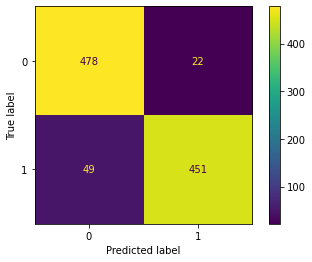

In [27]:
prediction_values = list(predictions.values())
cm = confusion_matrix(y_test, prediction_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [28]:
fn += cm[1][0]
fp += cm[0][1]
tn = cm[0][0]

In [29]:
#print(predictions)
correctly_predicted_sources_img_names = []
for img_name, pred in zip(predictions.keys(), predictions.values()):
    if img_name[0] == 's' and pred == 1:
        correctly_predicted_sources_img_names.append(img_name)

correctly_predicted_sources_img_names

['sim_gray_stretch12.png',
 'sim_gray_stretch285.png',
 'sim_gray_stretch291.png',
 'sim_gray_stretch246.png',
 'sim_gray_stretch252.png',
 'sim_gray_stretch497.png',
 'sim_gray_stretch483.png',
 'sim_gray_stretch468.png',
 'sim_gray_stretch332.png',
 'sim_gray_stretch454.png',
 'sim_gray_stretch440.png',
 'sim_gray_stretch326.png',
 'sim_gray_stretch118.png',
 'sim_gray_stretch130.png',
 'sim_gray_stretch124.png',
 'sim_gray_stretch125.png',
 'sim_gray_stretch131.png',
 'sim_gray_stretch119.png',
 'sim_gray_stretch441.png',
 'sim_gray_stretch327.png',
 'sim_gray_stretch333.png',
 'sim_gray_stretch455.png',
 'sim_gray_stretch469.png',
 'sim_gray_stretch482.png',
 'sim_gray_stretch496.png',
 'sim_gray_stretch253.png',
 'sim_gray_stretch247.png',
 'sim_gray_stretch13.png',
 'sim_gray_stretch11.png',
 'sim_gray_stretch292.png',
 'sim_gray_stretch286.png',
 'sim_gray_stretch279.png',
 'sim_gray_stretch251.png',
 'sim_gray_stretch245.png',
 'sim_gray_stretch494.png',
 'sim_gray_stretch325.p

In [30]:
import re
def extract_number_from_string(input_string):
    pattern = r'\d+'
    match = re.search(pattern, input_string)
    return int(match.group())

In [31]:
predicted_coords = []
true_coordinates_of_correctly_classified_sources = []
images_with_sources_correctly_classified = []
#image_names and x_test have the same order
for image_name, image in zip(image_names, x_test):
    if image_name in correctly_predicted_sources_img_names:
        coords_from_model = localization_model.predict(np.expand_dims(image, axis=0))
        predicted_coords.append(coords_from_model)
        index_image_name = extract_number_from_string(image_name)
        true_coordinates_of_correctly_classified_sources.append(true_coordinates[index_image_name])
        images_with_sources_correctly_classified.append(image)

# predicted_coords, true_coordinates_of_correctly_classified_sources and images_with_sources_correctly_classified have the same order

1/1 [==============================] - 0s 22ms/step


In [32]:
# measure the performances
skymap = 'sim.fits'
with fits.open(skymap) as hdul:
    wcs = WCS(hdul[0].header)
    for image, source_coords, true_coords in zip(images_with_sources_correctly_classified, predicted_coords, true_coordinates_of_correctly_classified_sources):
        # Add bounding box if source is predicted
        x, y = source_coords[0]  # Adjust coordinates according to your format
        true_coords = (int(true_coords[0]/8), int(true_coords[1]/8))
        predicted_skycoord = astropy.wcs.utils.pixel_to_skycoord(x, y, wcs)
        true_skycoord = astropy.wcs.utils.pixel_to_skycoord(true_coords[0], true_coords[1], wcs)
        error = predicted_skycoord.separation(true_skycoord).deg
        if error < 0.1:
            tp += 1
        else:
            fp += 1
        #print(error)

tn_acc = tn / NUM_TEST_BKGS
precision = tp / (tp + fp)
recall = tp / (tp + fn)
tn_acc = tn / NUM_TEST_BKGS
print("precision: " + str(precision))
print("recall: " + str(recall))
print("tn_acc: " + str(tn_acc))
print("tp = " + str(tp))
print("fp = " + str(fp))
print("fn = " + str(fn))
print("tn = " + str(tn))

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


precision: 0.9217758985200846
recall: 0.8989690721649485
tn_acc: 0.956
tp = 436
fp = 37
fn = 49
tn = 478


[[436  37]
 [ 49 478]]


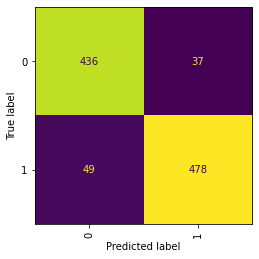

In [41]:
# Confusion matrix for CNN project
cm[0][0] = tp 
cm[0][1] = fp
cm[1][0] = fn
cm[1][1] = tn
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm) #display_labels=['source yes', '']
disp.plot(colorbar=False, xticks_rotation='vertical')

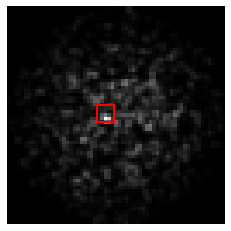

Real source coordinates:
(28, 31)
Predicted source coordinates:
(27, 30)
Error: 
0.08029507363236385


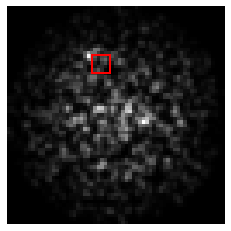

Real source coordinates:
(23, 13)
Predicted source coordinates:
(26, 16)
Error: 
0.7752432184936447


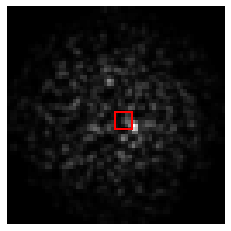

Real source coordinates:
(36, 34)
Predicted source coordinates:
(33, 32)
Error: 
0.5136232093674699


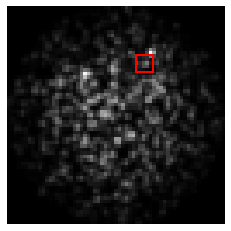

Real source coordinates:
(41, 12)
Predicted source coordinates:
(39, 16)
Error: 
0.710380923670968


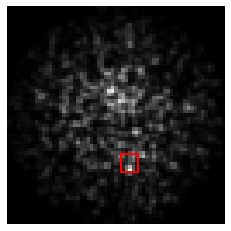

Real source coordinates:
(34, 46)
Predicted source coordinates:
(34, 44)
Error: 
0.22651571419801103


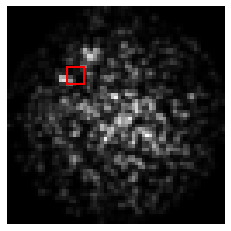

Real source coordinates:
(15, 20)
Predicted source coordinates:
(19, 19)
Error: 
0.6759465608965639


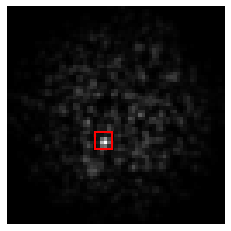

Real source coordinates:
(27, 38)
Predicted source coordinates:
(27, 38)
Error: 
0.07170480537715697


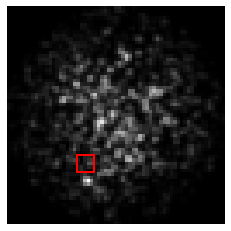

Real source coordinates:
(22, 50)
Predicted source coordinates:
(22, 44)
Error: 
0.8082800448328661


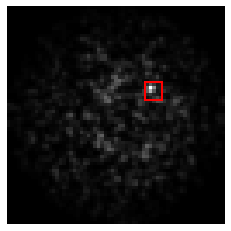

Real source coordinates:
(41, 23)
Predicted source coordinates:
(41, 24)
Error: 
0.20637386175838507


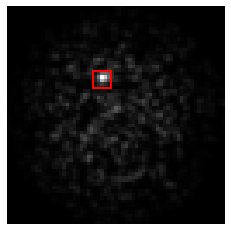

Real source coordinates:
(27, 20)
Predicted source coordinates:
(26, 20)
Error: 
0.12418118812359312


In [104]:
# visualize the localization predictions

check_idx = 0

for image, source_coords, true_coords in zip(images_with_sources_correctly_classified, predicted_coords, true_coordinates_of_correctly_classified_sources):
    # Display the test image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # Add bounding box if source is predicted
    x, y = source_coords[0]  # Adjust coordinates according to your format
    #x /= 8
    #y /= 8
    true_coords = (int(true_coords[0]/8), int(true_coords[1]/8))
    width = height = 5  # Adjust these values according to your desired box size
    rect = patches.Rectangle((x - width/2, y - height/2), width, height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()
    print("Real source coordinates:")
    print(true_coords)
    print("Predicted source coordinates:")
    print((int(x), int(y)))

    print("Error: ")
    real__scaled_skycoord = astropy.wcs.utils.pixel_to_skycoord(true_coords[0]*8, true_coords[1]*8, wcs)
    predicted_scaled_skycoord = astropy.wcs.utils.pixel_to_skycoord(x*8, y*8, wcs)
    print(real__scaled_skycoord.separation(predicted_scaled_skycoord).deg)
    
    check_idx += 1
    if check_idx == 10:
        break